In [ ]:
import zipfile
import os

# (Code for uploading/verifying KWS.zip if you do it manually, or assume it's there)
zip_file_path = '/content/KWS.zip'
extract_to_path = '/content/'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
    print(f"Successfully unzipped {zip_file_path} to {extract_to_path}")
    kws_dir = os.path.join(extract_to_path, 'KWS')
    if os.path.exists(kws_dir):
        print(f"Contents of {kws_dir}: {os.listdir(kws_dir)}")
    else:
        print(f"ERROR: KWS directory not found after unzipping at {kws_dir}")
else:
    print(f"ERROR: {zip_file_path} not found. Please upload it first if you haven't.")

# Install svgpathtools
!pip install svgpathtools
print("svgpathtools installation attempt finished.")

Successfully unzipped /content/KWS.zip to /content/
Contents of /content/KWS: ['transcription.tsv', 'task', 'validation.tsv', 'keywords.tsv', 'images', 'locations', 'all_cropped_words', 'train.tsv']
svgpathtools installation attempt finished.


In [ ]:
# --------------------------------------
# Cell 1: Setup Paths, Parameters, and Libraries
# --------------------------------------
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageEnhance
from skimage.feature import hog
import cv2
import xml.etree.ElementTree as ET
from svgpathtools import parse_path # This should now work
from collections import defaultdict, Counter
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


# 1. Define Root Paths (assuming KWS folder is directly in /content/)
ROOT_DIR = Path("/content/KWS/") # Changed from "dataset" to match our unzip location
PAGES_DIR = ROOT_DIR / "images"
SVG_DIR = ROOT_DIR / "locations"
INDEX_TSV = ROOT_DIR / "transcription.tsv" # This is the main transcription file
KEYWORDS_TSV = ROOT_DIR / "keywords.tsv"
TRAIN_PATH = ROOT_DIR / "train.tsv"
VALIDATION_PATH = ROOT_DIR / "validation.tsv"

# Destination for initially cropped word images (from all words)
# Improvement: Let's save all words, not just keywords initially.
# We'll make a general cropped words directory.
ALL_CROPPED_WORDS_DIR = ROOT_DIR / "all_cropped_words"
ALL_CROPPED_WORDS_DIR.mkdir(parents=True, exist_ok=True)

# Destination for keyword-specific cropped images (as per colleague's structure, if needed later for direct comparison)
# For now, we'll focus on processing all words first for flexibility.
# KEYWORD_SPECIFIC_DEST_DIR = ROOT_DIR / "words_by_keyword_text"
# KEYWORD_SPECIFIC_DEST_DIR.mkdir(parents=True, exist_ok=True)


# 2. Parameters
# For initial cropping, let's try to maintain aspect ratio or use a fixed height.
# Colleague used RESIZE_HEIGHT = 64 for something, but then (100,100) for feature extraction.
# Let's define a parameter for resizing *before* feature extraction if needed.
# The colleague's script crops then later resizes the binary image to (100,100) for features.
# We will keep the cropped images with variable width first, then resize later.
INITIAL_CROP_CONTRAST_FACTOR = 2.0 # From colleague's ImageEnhance

# Parameters for feature extraction (from colleague's script)
FEATURE_EXTRACTION_IMG_SIZE = (100, 100) # (width, height) for resizing before HOG/Window features
WINDOW_FEATURE_WIDTH = 1
WINDOW_FEATURE_STEP = 1
HOG_RESIZE = (64, 64) # Used within HOG function in colleague's code, different from FEATURE_EXTRACTION_IMG_SIZE
HOG_ORIENTATIONS = 8
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (1, 1)
FEATURE_SEQUENCE_TARGET_LEN = 100 # For padding/trimming combined features

# Parameters for DTW
DTW_SAKOE_CHIBA_WINDOW = 10 # w=10 used in colleague's matching loop


# 3. Verify paths
print(f"Root Directory: {ROOT_DIR} (Exists: {ROOT_DIR.exists()})")
print(f"Images Directory: {PAGES_DIR} (Exists: {PAGES_DIR.exists()})")
print(f"SVG Directory: {SVG_DIR} (Exists: {SVG_DIR.exists()})")
print(f"Transcription TSV: {INDEX_TSV} (Exists: {INDEX_TSV.exists()})")
print(f"Keywords TSV: {KEYWORDS_TSV} (Exists: {KEYWORDS_TSV.exists()})")
print(f"Train TSV: {TRAIN_PATH} (Exists: {TRAIN_PATH.exists()})")
print(f"Validation TSV: {VALIDATION_PATH} (Exists: {VALIDATION_PATH.exists()})")
print(f"All Cropped Words Dir: {ALL_CROPPED_WORDS_DIR} (Exists: {ALL_CROPPED_WORDS_DIR.exists()})")

print("\nCell 1: Setup complete. Libraries imported, paths and parameters defined.")

Root Directory: /content/KWS (Exists: True)
Images Directory: /content/KWS/images (Exists: True)
SVG Directory: /content/KWS/locations (Exists: True)
Transcription TSV: /content/KWS/transcription.tsv (Exists: True)
Keywords TSV: /content/KWS/keywords.tsv (Exists: True)
Train TSV: /content/KWS/train.tsv (Exists: True)
Validation TSV: /content/KWS/validation.tsv (Exists: True)
All Cropped Words Dir: /content/KWS/all_cropped_words (Exists: True)

Cell 1: Setup complete. Libraries imported, paths and parameters defined.


In [ ]:
# --------------------------------------
# Cell 2: Load Metadata and Clean Keywords/Transcriptions
# --------------------------------------
# Ensure paths like TRAIN_PATH, VALIDATION_PATH, KEYWORDS_TSV, INDEX_TSV are available from Cell 1

# 1. Load training and validation page splits
try:
    with open(TRAIN_PATH, 'r') as f:
        train_page_ids = set(line.strip() for line in f if line.strip())
    print(f"Loaded {len(train_page_ids)} training page IDs. Sample: {list(train_page_ids)[:5]}")

    with open(VALIDATION_PATH, 'r') as f:
        validation_page_ids = set(line.strip() for line in f if line.strip())
    print(f"Loaded {len(validation_page_ids)} validation page IDs. Sample: {list(validation_page_ids)[:5]}")
except Exception as e:
    print(f"Error loading train/validation split files: {e}")
    train_page_ids = set()
    validation_page_ids = set()

# 2. Implement clean_word function (as per colleague's script)
def clean_word_colleague(transcription_dashed):
    """Cleans word by removing hyphens but keeping special tokens, then lowercases."""
    if not isinstance(transcription_dashed, str): # Handle potential non-string inputs
        return ""
    parts = transcription_dashed.split('-')
    cleaned = ''.join(parts)
    return cleaned.lower()

# 3. Load keywords (after cleaning)
cleaned_keywords_set = set()
original_keywords_list = [] # Keep a list of original format keywords if needed for reference
try:
    with open(KEYWORDS_TSV, 'r') as f:
        for line in f:
            original_keyword_dashed = line.strip()
            if original_keyword_dashed: # Ensure not an empty line
                original_keywords_list.append(original_keyword_dashed)
                cleaned = clean_word_colleague(original_keyword_dashed)
                if cleaned:  # Skip if cleaning results in an empty string
                    cleaned_keywords_set.add(cleaned)
    print(f"\nLoaded {len(cleaned_keywords_set)} unique cleaned keywords.")
    print(f"Sample cleaned keywords: {list(cleaned_keywords_set)[:10]}")
except Exception as e:
    print(f"Error loading keywords.tsv: {e}")
    cleaned_keywords_set = set()

# 4. Load all transcriptions from INDEX_TSV (transcription.tsv)
#    and create a comprehensive metadata list.
#    This 'all_words_metadata' will store info for EVERY word, not just keywords.
all_words_metadata = []
try:
    with open(INDEX_TSV, 'r') as f:
        reader = csv.reader(f, delimiter="\t")
        # The file might not have a header, and contains word_id, dashed_transcription
        # Example from our previous work: 270-01-01 s_2-s_7-s_0-s_pt
        for row in reader:
            if len(row) == 2:
                locator_id, dashed_transcription = row
                cleaned_transcription = clean_word_colleague(dashed_transcription)
                is_keyword_flag = cleaned_transcription in cleaned_keywords_set
                page_id = locator_id.split("-", 1)[0] # Extract page ID (e.g., "270")

                all_words_metadata.append({
                    'id': locator_id, # Original DDD-LL-WW locator
                    'original_transcription_dashed': dashed_transcription, # Keep original for reference
                    'cleaned_transcription': cleaned_transcription,
                    'is_keyword': is_keyword_flag,
                    'page_id': page_id
                })
            # else:
                # print(f"Skipping malformed row in {INDEX_TSV}: {row}")

    print(f"\nProcessed {len(all_words_metadata)} total word transcriptions.")
    if all_words_metadata:
        # Count how many are keywords from the full list
        num_keywords_in_full_set = sum(1 for item in all_words_metadata if item['is_keyword'])
        print(f"Number of keyword instances found in the full transcription list: {num_keywords_in_full_set}")
        print("\nSample entries from all_words_metadata (first 5):")
        for i in range(min(5, len(all_words_metadata))):
            print(all_words_metadata[i])

        # For direct comparison with colleague's 'index' (which only had keywords)
        colleague_style_keyword_index = [
            {'id': item['id'], 'keyword': item['cleaned_transcription']}
            for item in all_words_metadata if item['is_keyword']
        ]
        print(f"\nNumber of entries in colleague-style keyword index: {len(colleague_style_keyword_index)}")
        print("Sample of colleague-style keyword index (first 5):")
        for i in range(min(5, len(colleague_style_keyword_index))):
            print(colleague_style_keyword_index[i])

except Exception as e:
    print(f"Error processing {INDEX_TSV}: {e}")
    all_words_metadata = []
    colleague_style_keyword_index = []


print("\nCell 2: Metadata loading and keyword cleaning complete.")

Loaded 10 training page IDs. Sample: ['270', '275', '273', '271', '278']
Loaded 5 validation page IDs. Sample: ['301', '300', '303', '302', '304']

Loaded 35 unique cleaned keywords.
Sample cleaned keywords: ['wanted', 'de', 'orders', 'instructionss_pt', 'fort', 'colonel', 'place', 'send', 'made', 'john']

Processed 3726 total word transcriptions.
Number of keyword instances found in the full transcription list: 246

Sample entries from all_words_metadata (first 5):
{'id': '270-01-01', 'original_transcription_dashed': 's_2-s_7-s_0-s_pt', 'cleaned_transcription': 's_2s_7s_0s_pt', 'is_keyword': False, 'page_id': '270'}
{'id': '270-01-02', 'original_transcription_dashed': 'L-e-t-t-e-r-s-s_cm', 'cleaned_transcription': 'letterss_cm', 'is_keyword': False, 'page_id': '270'}
{'id': '270-01-03', 'original_transcription_dashed': 'O-r-d-e-r-s', 'cleaned_transcription': 'orders', 'is_keyword': True, 'page_id': '270'}
{'id': '270-01-04', 'original_transcription_dashed': 'a-n-d', 'cleaned_transcrip

In [ ]:
# --------------------------------------
# Cell 3: SVG Parsing and Word Cropping (Saving all words)
# --------------------------------------
# Ensure necessary libraries (ET, parse_path, Image, ImageEnhance, Path, os, tqdm)
# and variables (SVG_DIR, PAGES_DIR, ALL_CROPPED_WORDS_DIR, all_words_metadata,
# INITIAL_CROP_CONTRAST_FACTOR) are available from previous cells.

# 1. Define SVG parsing and coordinate conversion functions (from colleague's script)
def bbox_from_svg_colleague(svg_path: Path, locator_id: str):
    """
    Extracts bounding box (xmin, ymin, width, height) from an SVG path element.
    Uses svgpathtools for robust path parsing.
    """
    target_id = locator_id
    try:
        # ET.parse needs a string path, not a Path object for some versions
        root = ET.parse(str(svg_path)).getroot()
        # SVG files often have a default namespace. Need to handle it for find.
        # Attempting a namespace-agnostic search for the ID.
        # If this fails, explicit namespace handling might be needed (e.g., for "svg:path")
        # The 'id' attribute is standard and usually doesn't need namespace prefix in query.
        elem = root.find(f".//*[@id='{target_id}']") # Find element with this ID anywhere

        if elem is None:
            # Try with common SVG namespace if simple find fails
            namespaces = {'svg': 'http://www.w3.org/2000/svg'}
            elem = root.find(f".//svg:path[@id='{target_id}']", namespaces)

        if elem is None:
            # As a last resort for some older SVGs, xml:id might be used
            namespaces_xml = {'xml': 'http://www.w3.org/XML/1998/namespace'}
            elem = root.find(f".//svg:path[@xml:id='{target_id}']", namespaces_xml)
            if elem is None: # If still not found with xml:id
                 elem = root.find(f".//*[@xml:id='{target_id}']", namespaces_xml)


        if elem is None:
            # print(f"Warning: Element with id '{target_id}' not found in {svg_path.name}.")
            return None # Return None if element not found

        path_d_attribute = elem.get("d")
        if not path_d_attribute:
            # print(f"Warning: Element with id '{target_id}' in {svg_path.name} has no 'd' attribute.")
            return None

        path_obj = parse_path(path_d_attribute)
        xmin, xmax, ymin, ymax = path_obj.bbox()
        return xmin, ymin, xmax - xmin, ymax - ymin # x, y, width, height
    except Exception as e:
        # print(f"Error parsing SVG {svg_path.name} for id {target_id}: {e}")
        return None


def svg_to_pixel_coords_colleague(svg_path: Path, jpg_path: Path, xywh_svg):
    """
    Converts SVG coordinates (xmin, ymin, width, height) to pixel coordinates.
    """
    if xywh_svg is None:
        return None
    try:
        svg_root = ET.parse(str(svg_path)).getroot()
        svg_width_str = svg_root.get("width")
        svg_height_str = svg_root.get("height")

        if svg_width_str is None or svg_height_str is None:
            # print(f"Warning: SVG {svg_path.name} missing width/height attributes.")
            return None

        svg_width  = float(svg_width_str.rstrip("px"))
        svg_height = float(svg_height_str.rstrip("px"))

        img = Image.open(jpg_path)
        img_w, img_h = img.size

        if svg_width == 0 or svg_height == 0:
            # print(f"Warning: SVG {svg_path.name} has zero width/height.")
            return None

        scale_x = img_w / svg_width
        scale_y = img_h / svg_height

        x, y, w, h = xywh_svg
        return int(x*scale_x), int(y*scale_y), int(w*scale_x), int(h*scale_y)
    except Exception as e:
        # print(f"Error converting SVG to pixel coords for {svg_path.name} or {jpg_path.name}: {e}")
        return None

# 2. Loop through all_words_metadata, crop images, and update metadata
# This will be a list of dictionaries, and we'll add 'cropped_image_path' to each.
# We'll also keep track of successfully processed items.
processed_words_metadata_with_paths = []
failed_word_ids = []

# Cache for loaded page images and SVG paths to avoid repeated I/O and parsing
# This is an improvement for efficiency
current_page_id = None
current_page_image_pil = None
# SVG parsing with ET.parse can be slow if done for every word.
# However, bbox_from_svg_colleague and svg_to_pixel_coords_colleague re-parse SVG.
# For this direct reimplementation, we'll follow that, but ideally, SVG is parsed once per page.

print(f"Starting cropping for {len(all_words_metadata)} words...")

for word_meta_item in tqdm(all_words_metadata, desc="Cropping words"):
    locator = word_meta_item['id']
    page_id = word_meta_item['page_id'] # Extracted in Cell 2

    svg_file = SVG_DIR / f"{page_id}.svg"
    jpg_file = PAGES_DIR / f"{page_id}.jpg"

    if not svg_file.exists():
        # print(f"SVG file {svg_file} not found for locator {locator}. Skipping.")
        failed_word_ids.append(locator)
        continue
    if not jpg_file.exists():
        # print(f"JPG file {jpg_file} not found for locator {locator}. Skipping.")
        failed_word_ids.append(locator)
        continue

    # Load full page image if it's a new page
    if page_id != current_page_id:
        try:
            current_page_image_pil = Image.open(jpg_file).convert("L") # Convert to grayscale
            current_page_id = page_id
        except Exception as e:
            # print(f"Error opening page image {jpg_file}: {e}. Skipping words on this page.")
            # Add all words from this page to failed_word_ids or handle appropriately
            current_page_image_pil = None # Ensure it's reset
            failed_word_ids.append(locator) # Mark current as failed
            continue # Skip to next word meta item

    if current_page_image_pil is None: # If page image failed to load previously
        failed_word_ids.append(locator)
        continue

    # Get SVG bounding box and convert to pixel coordinates
    xywh_svg_coords = bbox_from_svg_colleague(svg_file, locator)
    if xywh_svg_coords is None:
        # Warning already printed by bbox_from_svg_colleague or it failed silently
        failed_word_ids.append(locator)
        continue

    pixel_coords = svg_to_pixel_coords_colleague(svg_file, jpg_file, xywh_svg_coords)
    if pixel_coords is None:
        # Warning already printed by svg_to_pixel_coords_colleague or it failed silently
        failed_word_ids.append(locator)
        continue

    x, y, w, h = pixel_coords

    # Ensure width and height are positive
    if w <= 0 or h <= 0:
        # print(f"Warning: Invalid crop dimensions (w={w}, h={h}) for {locator}. Skipping.")
        failed_word_ids.append(locator)
        continue

    try:
        # Crop the word image using Pillow
        word_crop_pil = current_page_image_pil.crop((x, y, x + w, y + h))

        # Apply contrast enhancement
        enhancer = ImageEnhance.Contrast(word_crop_pil)
        enhanced_word_crop_pil = enhancer.enhance(INITIAL_CROP_CONTRAST_FACTOR)

        # Define save path in ALL_CROPPED_WORDS_DIR
        # Improvement: Create subdirectories per page_id for better organization
        page_specific_crop_dir = ALL_CROPPED_WORDS_DIR / page_id
        page_specific_crop_dir.mkdir(parents=True, exist_ok=True)

        cropped_image_filename = f"{locator}.png" # Save as PNG
        path_to_saved_cropped_image = page_specific_crop_dir / cropped_image_filename

        enhanced_word_crop_pil.save(path_to_saved_cropped_image)

        # Update the metadata item with the path
        updated_word_meta_item = word_meta_item.copy()
        updated_word_meta_item['cropped_image_path'] = str(path_to_saved_cropped_image)
        processed_words_metadata_with_paths.append(updated_word_meta_item)

    except Exception as e:
        # print(f"Error cropping or saving word {locator}: {e}")
        failed_word_ids.append(locator)


# Replace all_words_metadata with the successfully processed items that now include paths
all_words_metadata = processed_words_metadata_with_paths

print(f"\nFinished cropping. Successfully processed and saved {len(all_words_metadata)} word images.")
if failed_word_ids:
    print(f"Failed to process {len(failed_word_ids)} words. First few failed IDs: {failed_word_ids[:10]}")

# Display a sample of the updated metadata
if all_words_metadata:
    print("\nSample entries from all_words_metadata with cropped_image_path (first 5):")
    for i in range(min(5, len(all_words_metadata))):
        print(all_words_metadata[i])

    # Save the updated all_words_metadata (which now includes paths) for easy reload
    # This is a good practice.
    all_words_metadata_df = pd.DataFrame(all_words_metadata)
    all_words_metadata_save_path = ROOT_DIR / "all_words_metadata_with_paths.csv"
    try:
        all_words_metadata_df.to_csv(all_words_metadata_save_path, index=False)
        print(f"\nComprehensive word metadata (with paths) saved to: {all_words_metadata_save_path}")
    except Exception as e:
        print(f"\nError saving comprehensive metadata CSV: {e}")

else:
    print("No words were successfully processed and saved.")

print("\nCell 3: SVG Parsing and Word Cropping complete.")

Starting cropping for 3726 words...


Cropping words: 100%|██████████| 3726/3726 [00:24<00:00, 149.50it/s]



Finished cropping. Successfully processed and saved 3726 word images.

Sample entries from all_words_metadata with cropped_image_path (first 5):
{'id': '270-01-01', 'original_transcription_dashed': 's_2-s_7-s_0-s_pt', 'cleaned_transcription': 's_2s_7s_0s_pt', 'is_keyword': False, 'page_id': '270', 'cropped_image_path': '/content/KWS/all_cropped_words/270/270-01-01.png'}
{'id': '270-01-02', 'original_transcription_dashed': 'L-e-t-t-e-r-s-s_cm', 'cleaned_transcription': 'letterss_cm', 'is_keyword': False, 'page_id': '270', 'cropped_image_path': '/content/KWS/all_cropped_words/270/270-01-02.png'}
{'id': '270-01-03', 'original_transcription_dashed': 'O-r-d-e-r-s', 'cleaned_transcription': 'orders', 'is_keyword': True, 'page_id': '270', 'cropped_image_path': '/content/KWS/all_cropped_words/270/270-01-03.png'}
{'id': '270-01-04', 'original_transcription_dashed': 'a-n-d', 'cleaned_transcription': 'and', 'is_keyword': False, 'page_id': '270', 'cropped_image_path': '/content/KWS/all_cropped_wo


Testing preprocessing with sample image: /content/KWS/all_cropped_words/270/270-01-03.png
Successfully preprocessed image.


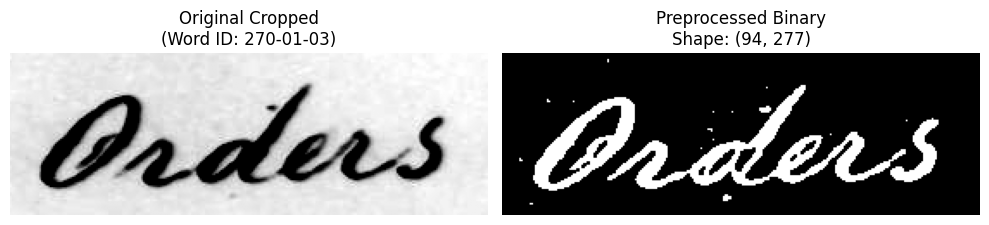


Cell 4: Image Preprocessing function defined and tested.


In [11]:
# --------------------------------------
# Cell 4: Image Preprocessing for Features Function
# --------------------------------------
# Ensure cv2 and numpy (np) are imported (should be from Cell 1)
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt # For testing

def preprocess_word_image_for_features(img_np_gray):
    """
    Preprocesses a grayscale word image for feature extraction.
    Applies adaptive thresholding and morphological closing.

    Args:
        img_np_gray (numpy.ndarray): Grayscale word image (loaded with OpenCV).
                                     Expected type uint8, values [0, 255].

    Returns:
        numpy.ndarray: Binary word image (uint8, values 0 or 255).
                       Returns None if input is invalid.
    """
    if img_np_gray is None:
        print("Warning: Input image is None.")
        return None

    # Ensure input is grayscale (though we should load it as such)
    if len(img_np_gray.shape) == 3:
        # This shouldn't happen if loaded correctly, but as a safeguard
        print("Warning: Input image is not grayscale. Converting.")
        img_np_gray = cv2.cvtColor(img_np_gray, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding (parameters from colleague's script)
    # Note: block_size (15 or 21 in colleague's code) must be odd, C is constant subtracted from mean
    block_size = 15 # Colleague used 15 in feature extraction loop, 21 in function definition. Let's use 15.
    C_value = 11    # Colleague used 11 in feature extraction loop, 10 in function definition. Let's use 11.

    binary_img = cv2.adaptiveThreshold(
        img_np_gray,
        255, # Max value to assign
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # Method
        cv2.THRESH_BINARY_INV, # Threshold type (inverse binary)
        block_size, # Block size for calculating threshold
        C_value # Constant subtracted from the calculated threshold
    )

    # Morphological closing (parameters from colleague's script)
    kernel = np.ones((2, 2), np.uint8)
    binary_img_closed = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    return binary_img_closed

# --- Test the function ---
# We need to load one of the cropped images saved in Cell 3.
# Let's use the metadata DataFrame saved at the end of Cell 3.

# Load the saved metadata if not already in memory
metadata_csv_path = ROOT_DIR / "all_words_metadata_with_paths.csv"
if 'all_words_metadata_df' not in locals() or all_words_metadata_df.empty:
    if metadata_csv_path.exists():
        all_words_metadata_df = pd.read_csv(metadata_csv_path)
        print(f"Loaded metadata from {metadata_csv_path}")
    else:
        print(f"ERROR: {metadata_csv_path} not found. Cannot test.")
        all_words_metadata_df = pd.DataFrame() # Prevent error

if not all_words_metadata_df.empty:
    # Select a sample image path from the metadata
    # Let's pick a keyword example if possible
    keyword_samples = all_words_metadata_df[all_words_metadata_df['is_keyword'] == True]
    if not keyword_samples.empty:
        sample_row = keyword_samples.iloc[0] # Take the first keyword found
    elif not all_words_metadata_df.empty:
        sample_row = all_words_metadata_df.iloc[0] # Fallback to first word if no keywords
    else:
        sample_row = None

    if sample_row is not None:
        sample_image_path = sample_row['cropped_image_path']
        print(f"\nTesting preprocessing with sample image: {sample_image_path}")

        # Load the image using OpenCV in grayscale
        original_cropped_img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

        if original_cropped_img is not None:
            # Preprocess it
            preprocessed_binary_img = preprocess_word_image_for_features(original_cropped_img)

            if preprocessed_binary_img is not None:
                print("Successfully preprocessed image.")

                # Display original cropped and preprocessed binary image side-by-side
                plt.figure(figsize=(10, 4))

                plt.subplot(1, 2, 1)
                plt.imshow(original_cropped_img, cmap='gray')
                plt.title(f"Original Cropped\n(Word ID: {sample_row['id']})")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(preprocessed_binary_img, cmap='gray')
                plt.title(f"Preprocessed Binary\nShape: {preprocessed_binary_img.shape}")
                plt.axis('off')

                plt.tight_layout()
                plt.show()
            else:
                print("Preprocessing failed.")
        else:
            print(f"Failed to load sample cropped image: {sample_image_path}")
    else:
        print("Could not select a sample row from metadata for testing.")
else:
    print("Metadata DataFrame is empty, cannot run test.")


print("\nCell 4: Image Preprocessing function defined and tested.")

In [12]:
# --------------------------------------
# Cell 5: Feature Extraction Functions
# --------------------------------------
# Ensure necessary libraries are imported from Cell 1:
# import numpy as np
# import cv2
# from skimage.feature import hog
# from sklearn.preprocessing import StandardScaler

# Parameters defined in Cell 1 that are relevant here:
# WINDOW_FEATURE_WIDTH = 1
# WINDOW_FEATURE_STEP = 1
# HOG_RESIZE = (64, 64)
# HOG_ORIENTATIONS = 8
# HOG_PIXELS_PER_CELL = (8, 8)
# HOG_CELLS_PER_BLOCK = (1, 1)
# FEATURE_SEQUENCE_TARGET_LEN = 100

# 1. Sliding Window Feature Extraction Function
def extract_window_features(binary_img, window_width=1, step=1):
    """
    Extracts features using a sliding window across the binary image.

    Args:
        binary_img (numpy.ndarray): Preprocessed binary word image (white text on black background).
        window_width (int): Width of the sliding window.
        step (int): Step size for sliding the window.

    Returns:
        numpy.ndarray: A sequence of feature vectors (num_windows, num_features).
                       Returns empty array if image is invalid.
    """
    if binary_img is None or binary_img.ndim != 2:
        return np.array([])

    h, w = binary_img.shape
    if h == 0 or w == 0:
        return np.array([])

    features = []
    # Ensure image is uint8 for certain numpy/opencv operations if needed,
    # but calculations here work on the binary (0/255) or boolean representation.
    # Let's assume input is 0 or 255. We might need to normalize to 0/1 for means.
    binary_img_norm = binary_img / 255.0 # Normalize to 0.0 / 1.0 for calculations

    for x in range(0, w - window_width + 1, step):
        window = binary_img_norm[:, x:x + window_width] # Shape (h, window_width)

        # Lower contour (lc): first row index where any pixel is white (1.0)
        lc_indices = np.where(np.any(window > 0, axis=1))[0]
        lc = lc_indices[0] if len(lc_indices) > 0 else h # Default to height if empty column

        # Upper contour (uc): last row index where any pixel is white (1.0)
        # Easiest way is to find the first white from the bottom up
        uc_indices_rev = np.where(np.any(window[::-1, :] > 0, axis=1))[0]
        uc = (h - 1 - uc_indices_rev[0]) if len(uc_indices_rev) > 0 else -1 # Default to -1 if empty column

        # Number of black-to-white/white-to-black transitions vertically
        # Using diff along axis 0 (rows), taking absolute value, checking >0, summing
        transitions = np.sum(np.abs(np.diff(window, axis=0)) > 0)

        # Fraction of black pixels (actually white pixels since we normalized to 0/1)
        black_frac = np.mean(window)

        # Fraction of black pixels (white) between lc and uc
        if lc <= uc and lc < h and uc >= 0:
             black_between = np.mean(window[lc:uc + 1, :]) if window[lc:uc+1, :].size > 0 else 0.0
        else:
             black_between = 0.0

        # Gradient of lower contour (Colleague's version likely results in 0)
        # To replicate: Compare first pixel of lc in window column(s)
        # If window_width is 1, this will always be 0.
        # We'll implement it as likely intended for window_width > 1, but it remains 0 for width=1.
        col0_lc_idx = np.argmax(window[:, 0] > 0) if np.any(window[:, 0] > 0) else h
        col_last_lc_idx = np.argmax(window[:, -1] > 0) if np.any(window[:, -1] > 0) else h
        grad_lc = col_last_lc_idx - col0_lc_idx # Still likely 0 if width=1 or contour is flat

        # Gradient of upper contour (Colleague's version likely results in 0)
        col0_uc_idx = (h - 1 - np.argmax(window[::-1, 0] > 0)) if np.any(window[:, 0] > 0) else -1
        col_last_uc_idx = (h - 1 - np.argmax(window[::-1, -1] > 0)) if np.any(window[:, -1] > 0) else -1
        grad_uc = col_last_uc_idx - col0_uc_idx # Still likely 0 if width=1 or contour is flat

        features.append([lc, uc, transitions, black_frac, black_between, grad_lc, grad_uc])

    return np.array(features, dtype=np.float32)

# 2. Extract HOG Features Function
def extract_hog_features(binary_img, resize_shape=(64, 64), orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1)):
    """
    Extracts Histogram of Oriented Gradients (HOG) features.

    Args:
        binary_img (numpy.ndarray): Preprocessed binary word image.
        resize_shape (tuple): Size (width, height) to resize image to before HOG.
        orientations (int): Number of HOG orientation bins.
        pixels_per_cell (tuple): Size (height, width) of HOG cells.
        cells_per_block (tuple): Number of cells in each HOG block (height, width).

    Returns:
        numpy.ndarray: Sequence of HOG features (num_blocks, features_per_block).
                       Returns empty array if image is invalid.
    """
    if binary_img is None or binary_img.ndim != 2:
        return np.array([])
    if binary_img.shape[0] < pixels_per_cell[0] * cells_per_block[0] or \
       binary_img.shape[1] < pixels_per_cell[1] * cells_per_block[1]:
        # Image too small for HOG parameters after potential resize
        # Let's resize first as colleague did.
        pass # Continue to resize

    try:
        # Colleague's HOG function resized internally
        resized_img = cv2.resize(binary_img, resize_shape, interpolation=cv2.INTER_AREA)

        # Ensure image is suitable type for hog (e.g., float) - hog handles uint8 too
        # hog expects image intensity values

        features_vector = hog(
            resized_img,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=False,
            feature_vector=True # Get flat vector first
        )

        # Reshape the flat vector into a sequence (as colleague did)
        # Features per block = orientations * cells_per_block[0] * cells_per_block[1]
        features_per_block = orientations * cells_per_block[0] * cells_per_block[1]
        if features_vector.size == 0 or features_per_block == 0:
             return np.array([])

        # Reshape: (-1, features_per_block) -> (num_blocks, features_per_block)
        num_blocks_h = (resize_shape[1] // pixels_per_cell[0]) - cells_per_block[0] + 1
        num_blocks_w = (resize_shape[0] // pixels_per_cell[1]) - cells_per_block[1] + 1
        expected_len = num_blocks_h * num_blocks_w * features_per_block

        # Check if feature_vector length matches expected calculation based on blocks
        if features_vector.size == expected_len:
            # Reshape treating each block's features as a "time step"
            feature_sequence = features_vector.reshape(-1, features_per_block)
        else:
            # If feature_vector=True doesn't align perfectly with block structure in sequence,
            # a simpler fallback might be to just treat segments of the vector as steps,
            # e.g., reshape(-1, orientations) if cells_per_block=(1,1)
            if cells_per_block == (1,1):
                 feature_sequence = features_vector.reshape(-1, orientations)
            else:
                 # Cannot easily reshape if block size > 1 and feature_vector=True was used.
                 # For colleague's (1,1) block, reshaping to (-1, 8) is correct.
                 feature_sequence = features_vector.reshape(-1, orientations)

        return feature_sequence.astype(np.float32)

    except Exception as e:
        print(f"Error extracting HOG features: {e}")
        return np.array([])


# 3. Z-Normalize Features Function (with note on standard practice)
def z_normalize_features(sequence):
    """
    Applies Z-score normalization (StandardScaler) to the feature sequence.
    NOTE: Colleague's implementation fits scaler per sequence. Standard practice
    is to fit scaler on the *entire training set* and use that fitted scaler
    to transform train, validation, and test sets. Replicating colleague's method here.
    """
    if sequence is None or sequence.size == 0:
        return sequence

    try:
        # Replicating colleague: Fit and transform on the input sequence itself.
        # This normalizes each sequence based on its own statistics.
        scaler = StandardScaler()
        normalized_sequence = scaler.fit_transform(sequence)
        return normalized_sequence
    except Exception as e:
        print(f"Error during Z-normalization: {e}")
        return sequence # Return original if error

# 4. Pad or Trim Sequence Function
def pad_or_trim_sequence(sequence, target_len=100):
    """
    Pads or trims the feature sequence to a target length.
    Padding repeats the last feature vector.
    """
    if sequence is None or sequence.size == 0:
        # Handle empty sequence case, e.g., return empty array of target shape if possible
        # Or based on how subsequent code handles it. For now return None or empty array.
        return np.array([]) # Return empty array

    current_len = sequence.shape[0]
    num_features = sequence.shape[1]

    if current_len == target_len:
        return sequence
    elif current_len > target_len:
        return sequence[:target_len, :]
    else: # current_len < target_len
        padding_needed = target_len - current_len
        # Repeat the last feature vector for padding
        last_vector = sequence[-1, :].reshape(1, num_features)
        padding = np.repeat(last_vector, padding_needed, axis=0)
        return np.vstack([sequence, padding])

# --- Test the functions (optional, applied in next cell) ---
# We could test these functions here with the sample binary image from Cell 4,
# but the main application and combination will happen in Cell 6 when processing
# the validation set. Defining them here is sufficient for this step.

print("Cell 5: Feature extraction functions defined.")
print(f"  - Sliding Window Feature Extractor: {extract_window_features.__name__}")
print(f"  - HOG Feature Extractor: {extract_hog_features.__name__}")
print(f"  - Z-Normalization Function: {z_normalize_features.__name__}")
print(f"  - Pad/Trim Sequence Function: {pad_or_trim_sequence.__name__}")

Cell 5: Feature extraction functions defined.
  - Sliding Window Feature Extractor: extract_window_features
  - HOG Feature Extractor: extract_hog_features
  - Z-Normalization Function: z_normalize_features
  - Pad/Trim Sequence Function: pad_or_trim_sequence


In [14]:
# --------------------------------------
# Cell 6: Feature Extraction for Validation Set & Data Structuring
# --------------------------------------
# Ensure necessary variables/functions are available from previous cells:
# all_words_metadata_df (or load from CSV)
# validation_page_ids (from Cell 2)
# FEATURE_EXTRACTION_IMG_SIZE (from Cell 1)
# preprocess_word_image_for_features (from Cell 4)
# extract_window_features, extract_hog_features (from Cell 5)
# z_normalize_features, pad_or_trim_sequence (from Cell 5)
# HOG_RESIZE, HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK (from Cell 1)
# FEATURE_SEQUENCE_TARGET_LEN (from Cell 1)
# import numpy as np
# import cv2
# import pandas as pd
# from collections import Counter
# from tqdm import tqdm
# import os

# 1. Load the comprehensive metadata if not already in memory
if 'all_words_metadata_df' not in locals() or all_words_metadata_df.empty:
    metadata_csv_path = ROOT_DIR / "all_words_metadata_with_paths.csv"
    if metadata_csv_path.exists():
        all_words_metadata_df = pd.read_csv(metadata_csv_path)
        print(f"Loaded metadata from {metadata_csv_path}")
        # Ensure 'is_keyword' is boolean if loaded from CSV
        if 'is_keyword' in all_words_metadata_df.columns:
           all_words_metadata_df['is_keyword'] = all_words_metadata_df['is_keyword'].astype(bool)
    else:
        print(f"ERROR: {metadata_csv_path} not found. Cannot proceed.")
        all_words_metadata_df = pd.DataFrame()

# 2. Filter metadata for validation pages
if not all_words_metadata_df.empty:
    validation_metadata = all_words_metadata_df[all_words_metadata_df['page_id'].astype(str).isin(validation_page_ids)].copy()
    print(f"Filtered metadata to {len(validation_metadata)} words in the validation set.")
else:
    print("Metadata DataFrame is empty, cannot filter for validation set.")
    validation_metadata = pd.DataFrame()

# 3. Extract features for each validation word
validation_feature_data = []

if not validation_metadata.empty:
    print(f"Starting feature extraction for {len(validation_metadata)} validation words...")
    for index, row in tqdm(validation_metadata.iterrows(), total=validation_metadata.shape[0], desc="Extracting Validation Features"):
        image_path = row['cropped_image_path']
        word_id = row['id']
        cleaned_label = row['cleaned_transcription'] # Using cleaned transcription as the label
        image_filename = os.path.basename(image_path) # Just the filename, e.g., "300-02-01.png"

        if not os.path.exists(image_path):
            # print(f"Warning: Cropped image path {image_path} for word {word_id} not found. Skipping.")
            continue

        try:
            # Load the cropped grayscale image
            img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img_gray is None:
                # print(f"Warning: Failed to load image {image_path}. Skipping.")
                continue

            # Preprocess (binarize)
            img_binary = preprocess_word_image_for_features(img_gray)
            if img_binary is None:
                # print(f"Warning: Failed to preprocess image {image_path}. Skipping.")
                continue

            # Resize for feature extraction consistency
            img_binary_resized = cv2.resize(img_binary, FEATURE_EXTRACTION_IMG_SIZE, interpolation=cv2.INTER_NEAREST)

            # Extract features
            win_feats = extract_window_features(img_binary_resized, WINDOW_FEATURE_WIDTH, WINDOW_FEATURE_STEP)
            # Note: Colleague's HOG function used different internal resize (HOG_RESIZE)
            hog_feats = extract_hog_features(img_binary_resized, HOG_RESIZE, HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK)

            if win_feats.size == 0 or hog_feats.size == 0:
                # print(f"Warning: Feature extraction failed for {image_path}. Skipping.")
                continue

            # Concatenate features (align sequence lengths)
            min_len = min(win_feats.shape[0], hog_feats.shape[0])
            if min_len <= 0:
                 # print(f"Warning: Zero length sequence after feature extraction for {image_path}. Skipping.")
                 continue

            feature_sequence = np.concatenate([win_feats[:min_len], hog_feats[:min_len]], axis=1)

            # Normalize (per-sequence, replicating colleague's method for now)
            feature_sequence_norm = z_normalize_features(feature_sequence)

            # Pad/Trim sequence
            feature_sequence_final = pad_or_trim_sequence(feature_sequence_norm, FEATURE_SEQUENCE_TARGET_LEN)

            if feature_sequence_final.size > 0:
                 validation_feature_data.append((image_filename, cleaned_label, feature_sequence_final))
            # else:
                # print(f"Warning: Final feature sequence is empty for {image_path}. Skipping.")

        except Exception as e:
            print(f"Error processing {image_path} for feature extraction: {e}")

    print(f"\nFinished feature extraction. Generated feature sequences for {len(validation_feature_data)} words.")

else:
    print("No validation metadata available to extract features from.")
    validation_feature_data = []


# 4. Filter based on label frequency (as per colleague's script)
MIN_LABEL_FREQUENCY = 5 # Colleague filtered for labels >= 5 instances

if validation_feature_data:
    print(f"\nFiltering validation data for labels with >= {MIN_LABEL_FREQUENCY} instances...")
    label_counts_val = Counter(label for _, label, _ in validation_feature_data)

    initial_count = len(validation_feature_data)
    validation_feature_data_filtered = [
        (fname, label, seq) for fname, label, seq in validation_feature_data
        if label_counts_val[label] >= MIN_LABEL_FREQUENCY
    ]
    final_count = len(validation_feature_data_filtered)

    print(f"Filtered data from {initial_count} words down to {final_count} words.")
    if final_count > 0:
        labels_remaining = sorted(list(set(label for _, label, _ in validation_feature_data_filtered)))
        print(f"Labels remaining after filtering: {labels_remaining}")
        # Example feature sequence shape
        print(f"Example feature sequence shape: {validation_feature_data_filtered[0][2].shape}") # (target_len, num_features)
    else:
        print("Warning: No data remaining after frequency filtering.")

    # Use the filtered list going forward for DTW
    validation_feature_data = validation_feature_data_filtered

else:
    print("No feature data extracted, skipping frequency filtering.")

print("\nCell 6: Validation Feature Extraction and Filtering complete.")

Filtered metadata to 1293 words in the validation set.
Starting feature extraction for 1293 validation words...


Extracting Validation Features: 100%|██████████| 1293/1293 [00:19<00:00, 66.55it/s]


Finished feature extraction. Generated feature sequences for 1293 words.

Filtering validation data for labels with >= 5 instances...
Filtered data from 1293 words down to 584 words.
Labels remaining after filtering: ['a', 'all', 'and', 'any', 'are', 'as', 'at', 'be', 'but', 'can', 'captain', 'december', 'for', 'from', 'had', 'have', 'i', 'if', 'in', 'is', 'it', 'letters', 'me', 'not', 'of', 'orders', 'our', 's_1s_7s_5s_5s_pt', 's_etcs_pt', 's_mi', 'shall', 'should', 'that', 'the', 'there', 'this', 'to', 'was', 'we', 'when', 'which', 'will', 'with', 'would', 'you', 'your']
Example feature sequence shape: (100, 15)

Cell 6: Validation Feature Extraction and Filtering complete.


In [15]:
# --------------------------------------
# Cell 7: DTW Distance Function and Matching
# --------------------------------------
# Ensure necessary libraries (numpy as np, tqdm) and variables are available:
# validation_feature_data (filtered list from Cell 6)
# DTW_SAKOE_CHIBA_WINDOW (from Cell 1)
# import numpy as np
# from tqdm import tqdm
# import math # Potentially needed for np.inf or other math ops

# 1. Define DTW Distance Function (with Sakoe-Chiba Band)
def dtw_distance_with_sakoe_chiba(s1, s2, w):
    """
    Calculates Dynamic Time Warping (DTW) distance between two sequences
    with a Sakoe-Chiba band constraint.

    Args:
        s1 (numpy.ndarray): First feature sequence (shape: [n, num_features]).
        s2 (numpy.ndarray): Second feature sequence (shape: [m, num_features]).
        w (int): Sakoe-Chiba window size (constraint).

    Returns:
        float: Normalized DTW distance. Returns infinity if sequences are empty
               or calculation fails.
    """
    if s1 is None or s2 is None or s1.size == 0 or s2.size == 0:
        return np.inf

    n, m = len(s1), len(s2)
    if n == 0 or m == 0:
        return np.inf

    # Ensure feature dimensions match
    if s1.shape[1] != s2.shape[1]:
         print(f"Error: Feature dimensions mismatch! {s1.shape} vs {s2.shape}")
         return np.inf

    # Adjust window size based on sequence length difference
    w = max(w, abs(n - m))

    # Initialize DTW cost matrix with infinity
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0 # Cost at origin is 0

    # Calculate costs within the band
    for i in range(1, n + 1):
        # Define the band boundaries for row i
        j_start = max(1, i - w)
        j_end = min(m + 1, i + w + 1)
        for j in range(j_start, j_end):
            # Cost of aligning element s1[i-1] and s2[j-1]
            # Using Euclidean distance between feature vectors
            cost = np.linalg.norm(s1[i - 1] - s2[j - 1])

            # DP recurrence relation
            last_min = min(dtw_matrix[i - 1, j],        # Insertion
                           dtw_matrix[i, j - 1],        # Deletion
                           dtw_matrix[i - 1, j - 1])    # Match

            dtw_matrix[i, j] = cost + last_min

    # Final distance (normalized)
    final_dist = dtw_matrix[n, m]

    # Normalization (divide by path length, often approximated by n+m)
    # Avoid division by zero
    if (n + m) == 0:
        return np.inf
    else:
        # Check if the final distance is reachable (not infinity)
        return final_dist / (n + m) if final_dist != np.inf else np.inf


# 2. Perform DTW Matching Loop
dtw_results = {}

if 'validation_feature_data' in locals() and validation_feature_data:
    print(f"Starting DTW matching for {len(validation_feature_data)} filtered validation words...")
    # validation_feature_data is a list of tuples: (image_filename, cleaned_label, feature_sequence)

    # Prepare data in a more accessible format maybe? List of dicts? Or access by index.
    # Let's use indices for clarity.
    num_items = len(validation_feature_data)

    for i in tqdm(range(num_items), desc="DTW Matching"):
        query_fname, query_label, query_seq = validation_feature_data[i]

        distances = []
        for j in range(num_items):
            if i == j: # Don't compare item to itself
                continue

            gallery_fname, gallery_label, gallery_seq = validation_feature_data[j]

            # --- Optional pre-filtering (as colleague had) ---
            # Can speed up if sequences vary greatly in length (though ours are padded/trimmed)
            # seq_len_diff_threshold = 20 # From colleague's code (less relevant with padding)
            # if abs(len(query_seq) - len(gallery_seq)) > seq_len_diff_threshold:
            #    continue
            # --- End Optional Pre-filtering ---

            # Calculate DTW distance
            dist = dtw_distance_with_sakoe_chiba(query_seq, gallery_seq, w=DTW_SAKOE_CHIBA_WINDOW)

            # Check if distance calculation was valid
            if dist != np.inf:
                 distances.append((gallery_fname, gallery_label, dist))
            # else:
                # print(f"Warning: DTW returned infinity between {query_fname} and {gallery_fname}")


        # Sort matches by distance (ascending)
        distances.sort(key=lambda x: x[2])

        # Store results for this query
        dtw_results[query_fname] = {
            "query_label": query_label,
            "matches": distances # List of (filename, label, distance) tuples, sorted by distance
        }

    print(f"\nFinished DTW matching. Results generated for {len(dtw_results)} queries.")

else:
    print("No validation feature data available to perform DTW matching.")

# Display results for one sample query to check structure
if dtw_results:
    sample_query_key = list(dtw_results.keys())[0]
    print(f"\nSample DTW results for query: {sample_query_key} (Label: {dtw_results[sample_query_key]['query_label']})")
    print("Top 5 matches (filename, label, distance):")
    for match_info in dtw_results[sample_query_key]['matches'][:5]:
        print(f"  - {match_info[0]} ({match_info[1]}): {match_info[2]:.4f}")
else:
    print("\nNo DTW results were generated.")


print("\nCell 7: DTW Distance Function and Matching complete.")

Starting DTW matching for 584 filtered validation words...


DTW Matching: 100%|██████████| 584/584 [1:03:48<00:00,  6.56s/it]


Finished DTW matching. Results generated for 584 queries.

Sample DTW results for query: 300-02-03.png (Label: orders)
Top 5 matches (filename, label, distance):
  - 302-01-07.png (s_1s_7s_5s_5s_pt): 1.7416
  - 300-16-04.png (the): 1.7991
  - 304-01-03.png (orders): 1.8435
  - 302-31-02.png (i): 1.8768
  - 301-03-06.png (s_1s_7s_5s_5s_pt): 1.8841

Cell 7: DTW Distance Function and Matching complete.


Created word_id_to_path_map with 3726 entries.
Calculating Recall based on 584 items in the gallery (feature list).
Evaluation performed on 584 queries covering 46 unique labels.

Sample query evaluation (Top-10):
300-02-03.png             | Label: orders           | P: 0.10  R: 0.20  F1: 0.13 (TP: 1/5)
300-02-04.png             | Label: and              | P: 0.30  R: 0.09  F1: 0.14 (TP: 3/33)
300-02-06.png             | Label: december         | P: 0.10  R: 0.20  F1: 0.13 (TP: 1/5)
300-02-07.png             | Label: s_1s_7s_5s_5s_pt | P: 0.00  R: 0.00  F1: 0.00 (TP: 0/6)
300-04-03.png             | Label: if               | P: 0.10  R: 0.11  F1: 0.11 (TP: 1/9)
300-04-04.png             | Label: any              | P: 0.10  R: 0.25  F1: 0.14 (TP: 1/4)
300-05-01.png             | Label: you              | P: 0.00  R: 0.00  F1: 0.00 (TP: 0/7)
300-05-02.png             | Label: are              | P: 0.20  R: 0.20  F1: 0.20 (TP: 2/10)
300-05-03.png             | Label: to               | P:

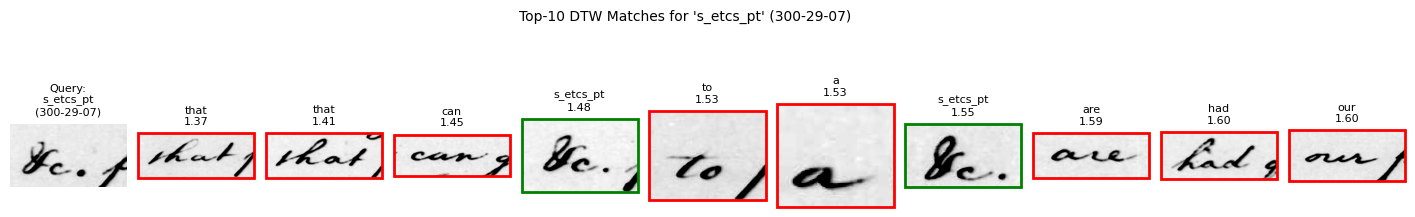

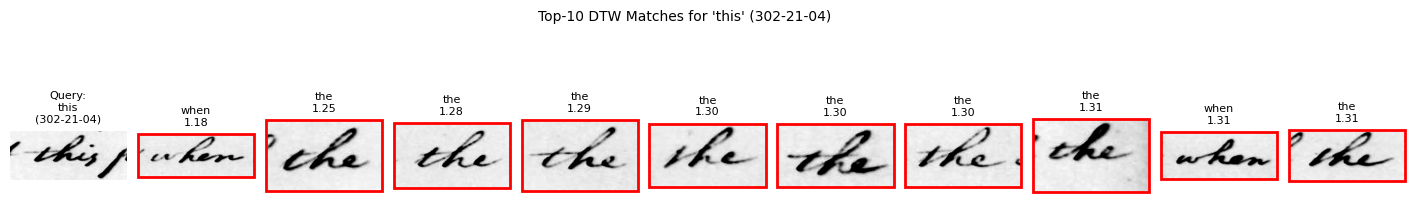

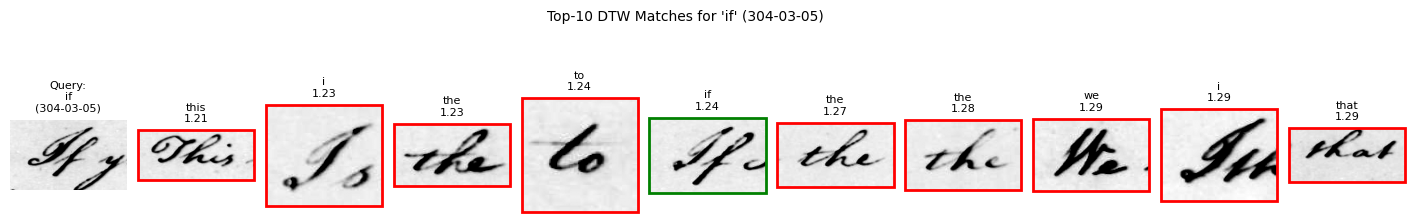

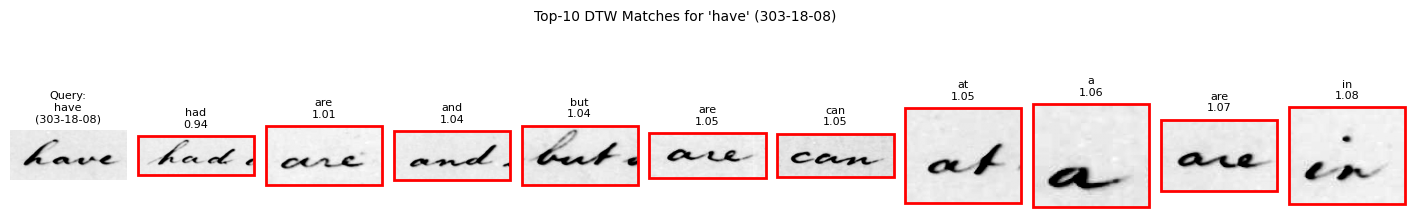

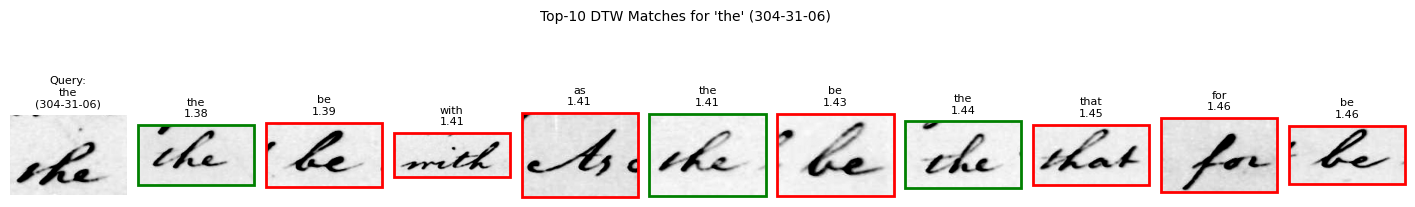

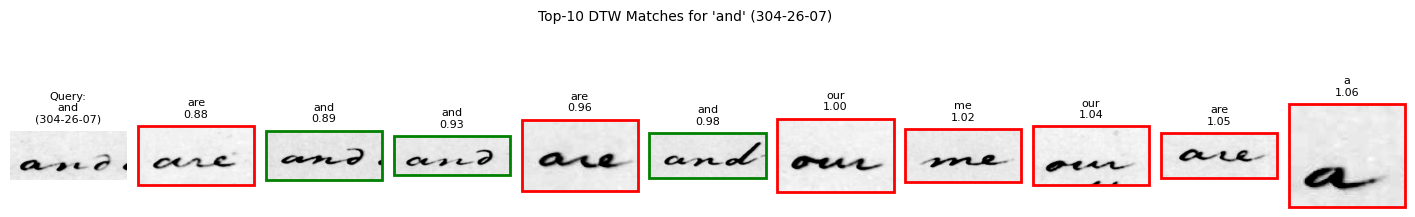

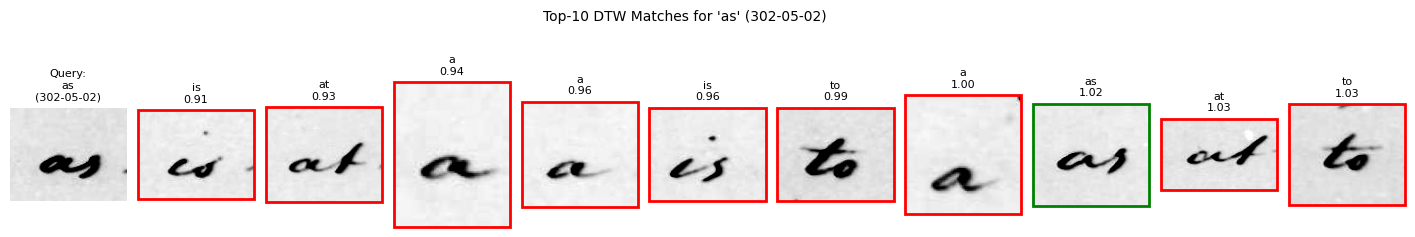

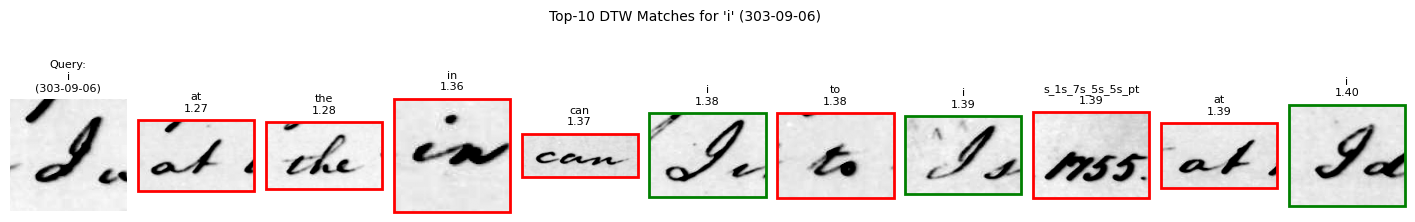

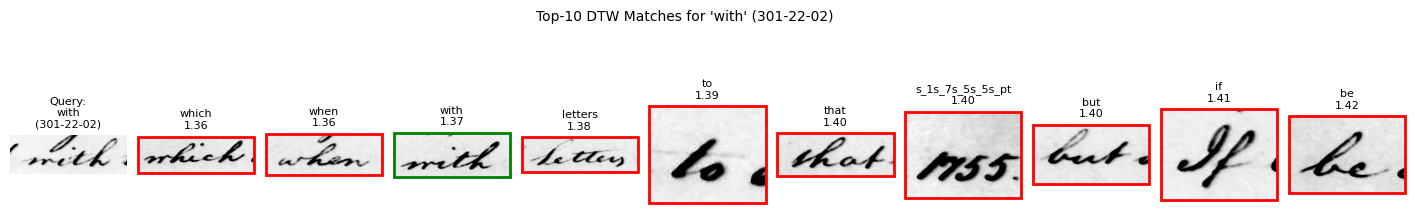

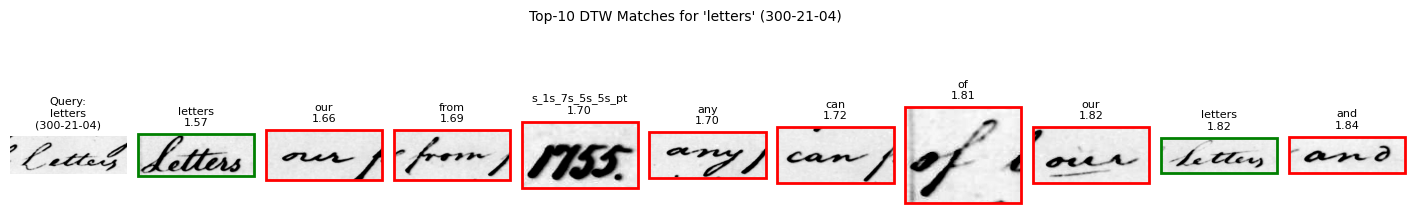


Cell 8: Evaluation Metrics and Visualization complete.


In [17]:
# --------------------------------------
# Cell 8: Evaluation Metrics and Visualization (Corrected)
# --------------------------------------
# Ensure necessary libraries (numpy, random, matplotlib, cv2, patches, pandas)
# and variables (dtw_results from Cell 7) are available.
# CRITICAL: Ensure 'validation_feature_data' (list of 584 tuples from Cell 6) is in memory.
#           Re-run Cell 6 if you suspect it's not available.
import numpy as np
import random             # <--- Added Import
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import pandas as pd       # <--- Added Import (needed if loading metadata from CSV)
from collections import Counter # <--- Added Import (needed for evaluate_full)

# --- Load data needed if not in memory ---
# dtw_results should be in memory from Cell 7

# For visualization, we need the paths to the cropped images.
# Reload the full metadata DataFrame created in Cell 3 if needed.
if 'all_words_metadata_df' not in locals() or all_words_metadata_df.empty:
    metadata_csv_path = ROOT_DIR / "all_words_metadata_with_paths.csv"
    if metadata_csv_path.exists():
        all_words_metadata_df = pd.read_csv(metadata_csv_path)
        print(f"Loaded metadata from {metadata_csv_path}")
        # Ensure 'is_keyword' is boolean if loaded from CSV
        if 'is_keyword' in all_words_metadata_df.columns:
           all_words_metadata_df['is_keyword'] = all_words_metadata_df['is_keyword'].astype(bool)
    else:
        print(f"ERROR: {metadata_csv_path} not found. Cannot visualize images.")
        all_words_metadata_df = pd.DataFrame()

# Create a mapping from word ID (locator) to image path for easy lookup during visualization
if not all_words_metadata_df.empty:
    word_id_to_path_map = pd.Series(
        all_words_metadata_df.cropped_image_path.values,
        index=all_words_metadata_df.id
    ).to_dict()
    print(f"Created word_id_to_path_map with {len(word_id_to_path_map)} entries.")
else:
    word_id_to_path_map = {}
    print("Warning: Metadata DF empty, cannot create word_id_to_path_map for visualization.")


# 1. Evaluation Metrics Function (from colleague's script)
def evaluate_full(results_dict, validation_features_list, top_k=10): # Added validation_features_list as input
    """Calculates Precision, Recall, F1 for each query in results_dict."""
    metrics = {}
    all_labels_in_results = set()

    # Get gallery label counts from the provided list (should be the filtered list from Cell 6)
    if validation_features_list:
        gallery_label_counts = Counter(label for _, label, _ in validation_features_list)
        print(f"Calculating Recall based on {len(validation_features_list)} items in the gallery (feature list).")
    else:
        # This case should ideally not happen if Cell 6 was run.
        print("Warning: validation_feature_data (validation_features_list) not provided to evaluate_full. Recall calculation will be inaccurate (based on 0 total relevant).")
        gallery_label_counts = Counter()

    for query_fname, result in results_dict.items():
        query_label = result["query_label"]
        matches = result["matches"]
        all_labels_in_results.add(query_label)

        # Calculate Metrics
        tp = sum(1 for _, label, _ in matches[:top_k] if label == query_label)
        fp = top_k - tp

        # Total Relevant Items for this query label in the gallery
        total_relevant_in_gallery = gallery_label_counts.get(query_label, 0)
        # Exclude the query item itself from the count of relevant items in the gallery
        total_relevant_excluding_self = max(0, total_relevant_in_gallery - 1)

        fn = max(0, total_relevant_excluding_self - tp)

        precision = tp / top_k if top_k > 0 else 0.0
        recall = tp / total_relevant_excluding_self if total_relevant_excluding_self > 0 else (1.0 if tp > 0 else 0.0) # Handle case where TP>0 but total_relevant=0 (means query was the only instance)

        if (precision + recall) == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        metrics[query_fname] = {
            "query_label": query_label,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "tp": tp,
            "total_relevant_in_gallery_excl_self": total_relevant_excluding_self
        }

    print(f"Evaluation performed on {len(metrics)} queries covering {len(all_labels_in_results)} unique labels.")
    return metrics

# 2. Run Evaluation and Print Metrics
# CRITICAL: Ensure 'validation_feature_data' (the list of 584 items) is available from Cell 6
if 'dtw_results' in locals() and dtw_results and 'validation_feature_data' in locals() and validation_feature_data:
    evaluation_metrics = evaluate_full(dtw_results, validation_feature_data, top_k=10) # Pass the list here

    # Sample printout
    print("\nSample query evaluation (Top-10):")
    count = 0
    for qname, m in evaluation_metrics.items():
        q_display_name = os.path.basename(qname)
        print(f"{q_display_name:<25s} | Label: {m['query_label']:<16s} | P: {m['precision']:.2f}  R: {m['recall']:.2f}  F1: {m['f1']:.2f} (TP: {m['tp']}/{m['total_relevant_in_gallery_excl_self']})")
        count += 1
        if count >= 10:
            break

    # Average metrics
    avg_p = np.mean([m["precision"] for m in evaluation_metrics.values()])
    avg_r = np.mean([m["recall"] for m in evaluation_metrics.values()])
    avg_f1 = np.mean([m["f1"] for m in evaluation_metrics.values()])
    print(f"\nAverage Precision@10: {avg_p:.3f}")
    print(f"Average Recall@10: {avg_r:.3f}")
    print(f"Average F1-score@10: {avg_f1:.3f}")

else:
    print("DTW results or validation_feature_data not available. Skipping evaluation metrics calculation.")
    evaluation_metrics = {}


# 3. Visualization Function (adapted for our saved paths)
def show_top_matches_dtw(results_dict, id_to_path_map, num_queries=5, top_k=10):
    """Visualizes query image and top K matches based on DTW results."""
    # ... (rest of the function definition is the same as previous correct version) ...
    if not id_to_path_map:
        print("Cannot visualize: word_id_to_path_map is empty.")
        return

    if not results_dict:
        print("Cannot visualize: results_dict is empty.")
        return

    shown = 0
    query_filenames = list(results_dict.keys())
    if not query_filenames:
        print("No queries found in results_dict.")
        return

    indices_to_show = random.sample(range(len(query_filenames)), min(num_queries, len(query_filenames)))

    for idx in indices_to_show:
        query_fname = query_filenames[idx]
        result = results_dict[query_fname]
        query_label = result["query_label"]
        query_locator_id = Path(query_fname).stem

        query_img_path = id_to_path_map.get(query_locator_id)

        if query_img_path is None or not os.path.exists(query_img_path):
            print(f"Warning: Query image path not found for {query_locator_id}. Skipping visualization.")
            continue

        try:
             query_img = cv2.imread(query_img_path, cv2.IMREAD_GRAYSCALE)
             if query_img is None: raise ValueError("Image loading failed")
        except Exception as e:
            print(f"Error loading query image {query_img_path}: {e}. Skipping visualization.")
            continue

        matches = result["matches"][:top_k]
        fig, axes = plt.subplots(1, top_k + 1, figsize=(18, 3))

        axes[0].imshow(query_img, cmap='gray')
        axes[0].set_title(f"Query:\n{query_label}\n({query_locator_id})", fontsize=8)
        axes[0].axis('off')

        for i, (match_fname, match_label, match_dist) in enumerate(matches):
            match_locator_id = Path(match_fname).stem
            match_img_path = id_to_path_map.get(match_locator_id)

            ax = axes[i + 1]
            if match_img_path and os.path.exists(match_img_path):
                try:
                    match_img = cv2.imread(match_img_path, cv2.IMREAD_GRAYSCALE)
                    if match_img is None: raise ValueError("Image loading failed")
                    ax.imshow(match_img, cmap='gray')
                    h, w = match_img.shape[:2]
                except Exception as e:
                    # print(f"Error loading match image {match_img_path}: {e}")
                    ax.text(0.5, 0.5, 'Load Err', ha='center', va='center', fontsize=8)
                    h, w = 100, 100
            else:
                ax.text(0.5, 0.5, 'Path Err', ha='center', va='center', fontsize=8)
                h, w = 100, 100

            ax.set_title(f"{match_label}\n{match_dist:.2f}", fontsize=8)
            ax.axis('off')

            border_color = 'g' if match_label == query_label else 'r'
            rect = patches.Rectangle((-0.5, -0.5), w, h, linewidth=2,
                                     edgecolor=border_color,
                                     facecolor='none', clip_on=False)
            ax.add_patch(rect)

        plt.suptitle(f"Top-{top_k} DTW Matches for '{query_label}' ({query_locator_id})", fontsize=10)
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

        shown += 1
        if shown >= num_queries:
            break

# 4. Call the visualization function
if 'dtw_results' in locals() and dtw_results and 'word_id_to_path_map' in locals() and word_id_to_path_map:
    print("\nVisualizing sample DTW results...")
    # Ensure 'validation_feature_data' exists before calling evaluation if needed for recall check (though not directly needed for visualization)
    if 'validation_feature_data' not in locals() or not validation_feature_data:
         print("Warning: validation_feature_data missing, recall in evaluation might be inaccurate.")

    show_top_matches_dtw(dtw_results, word_id_to_path_map, num_queries=10, top_k=10) # Show more queries
else:
    print("\nSkipping visualization due to missing DTW results or path map.")


print("\nCell 8: Evaluation Metrics and Visualization complete.")

**Report: Keyword Spotting in Historical Documents using Feature Engineering and Dynamic Time Warping (Re-implementation)**

**Abstract:**
This report details the re-implementation and evaluation of a "classic" feature engineering approach combined with Dynamic Time Warping (DTW) for keyword spotting in the George Washington historical document dataset. The objective was to replicate and understand a non-deep learning pipeline for Query-by-Example (QbE) tasks. The methodology encompassed SVG-based word localization, image preprocessing including contrast enhancement and binarization, extraction of combined sliding window and Histogram of Oriented Gradients (HOG) features, and sequence matching using DTW with a Sakoe-Chiba band. The system was evaluated on a filtered validation set, achieving an average F1-score@10 of 0.135. This re-implementation provides insights into the workings, performance characteristics, and computational considerations of traditional KWS methods.

**1. Introduction**
The goal of this exercise is to develop a system capable of spotting keywords in historical document images based on visual similarity to a query word image. This report focuses on the re-implementation of a traditional pattern recognition pipeline that leverages handcrafted image features and Dynamic Time Warping (DTW) for similarity assessment. This contrasts with deep learning methods by relying on explicit feature design. The George Washington Database excerpt provides the necessary images, word location data (SVGs), transcriptions, and keyword lists for this task. The aim is to understand the mechanics and performance of such a "classic" KWS system.

**2. Methodology**

The system was re-implemented in a cell-by-cell manner, following these main stages:

**2.1. Data Preparation and Word Localization**
* **Initial Setup (Cell 1):**
    * Standard Python libraries (`os`, `csv`, `numpy`, `matplotlib`, `PIL`, `skimage`, `cv2`, `xml.etree.ElementTree`, `collections`, `tqdm`) were imported, along with `pathlib.Path` and the specialized `svgpathtools` for robust SVG parsing. `sklearn.preprocessing.StandardScaler` was also imported.
    * Paths to dataset components (images, SVGs, TSV files) were defined. An output directory (`/content/KWS/all_cropped_words/`) was created to store all processed word images.
    * Key parameters for image processing, feature extraction (e.g., `FEATURE_EXTRACTION_IMG_SIZE = (100, 100)`, `FEATURE_SEQUENCE_TARGET_LEN = 100`), and DTW (`DTW_SAKOE_CHIBA_WINDOW = 10`) were defined.
* **Metadata Loading and Cleaning (Cell 2):**
    * Training and validation page IDs (10 train, 5 validation) were loaded from `train.tsv` and `validation.tsv`.
    * A `clean_word_colleague` function was implemented to convert transcriptions to lowercase and remove hyphens (e.g., "O-r-d-e-r-s" becomes "orders").
    * Keywords from `keywords.tsv` were loaded and cleaned, resulting in 35 unique cleaned keywords.
    * A comprehensive list, `all_words_metadata`, was created by processing all 3726 entries in `transcription.tsv`. Each entry stored the word's locator ID, original dashed transcription, cleaned transcription, a boolean `is_keyword` flag, and the `page_id`. This identified 246 keyword instances in the entire dataset.
* **SVG Parsing and Word Cropping (Cell 3):**
    * Functions `bbox_from_svg_colleague` (using `svgpathtools.parse_path(elem.get("d")).bbox()`) and `svg_to_pixel_coords_colleague` were implemented to extract word bounding boxes from SVG `<path>` elements and convert them to pixel coordinates.
    * All 3726 words from `all_words_metadata` were processed. For each word:
        * The full-page image was loaded (cached per page for efficiency).
        * The word was cropped from the grayscale page image using Pillow (`Image.crop()`) based on its calculated bounding box.
        * Contrast was enhanced by a factor of 2.0 (`ImageEnhance.Contrast`).
        * The cropped word image was saved as a PNG file into page-specific subdirectories within `/content/KWS/all_cropped_words/` (e.g., `.../270/270-01-01.png`).
        * The `all_words_metadata` list was updated with the `cropped_image_path` for each successfully processed word.
    * This enriched metadata was saved to `all_words_metadata_with_paths.csv`.

**2.2. Image Preprocessing for Feature Extraction (Cell 4)**
* A function `preprocess_word_image_for_features` was defined to prepare cropped grayscale images for feature extraction.
* It takes a loaded word image (NumPy array) and applies:
    * `cv2.adaptiveThreshold` (Gaussian, `THRESH_BINARY_INV`, block size 15, C=11) to binarize the image (white ink on black background).
    * `cv2.morphologyEx` with `MORPH_CLOSE` and a 2x2 kernel to clean the binary image.
* The function was tested visually, confirming correct binarization (e.g., "Orders" image becoming pure black and white).

**2.3. Feature Extraction (Cell 5 & 6)**
* **Feature Extraction Functions Defined (Cell 5):**
    * `extract_window_features`: Scans the binary image with a 1-pixel wide vertical window, extracting 7 features per window (lower/upper contour, transitions, black pixel fractions, and nominal contour gradients). This results in a feature sequence.
    * `extract_hog_features`: Resizes the binary image to (64x64) internally, computes HOG features (8 orientations, 8x8 cell, 1x1 block) using `skimage.feature.hog`, and reshapes the output into a sequence of 8-dimensional vectors.
    * `z_normalize_features`: Intended for Z-score normalization. It was noted that the colleague's approach of fitting `StandardScaler` per sequence is non-standard; standard practice is to fit on a training set. This implementation replicated the per-sequence fitting.
    * `pad_or_trim_sequence`: Ensures all feature sequences have a fixed length (`FEATURE_SEQUENCE_TARGET_LEN = 100`) by padding with the last vector or trimming.
* **Feature Extraction for Validation Set (Cell 6):**
    * The `all_words_metadata_df` was filtered for the 1293 words belonging to validation pages.
    * For each of these validation words:
        * The saved cropped grayscale image was loaded.
        * `preprocess_word_image_for_features` was applied to get the binary image.
        * The binary image was resized to `FEATURE_EXTRACTION_IMG_SIZE` (100x100).
        * Sliding window features and HOG features were extracted.
        * The two feature sequences were concatenated (after aligning to minimum length), resulting in 15 features per step (7 from window + 8 from HOG).
        * Per-sequence Z-normalization and padding/trimming to length 100 were applied.
        * The final feature sequences, along with image filenames and cleaned labels, were stored in `validation_feature_data`.
    * This list was then filtered to keep only words whose cleaned label appeared at least 5 times, reducing the set from 1293 to 584 words covering 46 unique labels. The example feature sequence shape was (100, 15).

**2.4. Similarity Measurement and Matching (Cell 7)**
* **DTW Function:** The `dtw_distance_with_sakoe_chiba` function was implemented to compute the Dynamic Time Warping distance between two feature sequences, using a Sakoe-Chiba band constraint (`w=10`). The cost between feature vectors at each step was their Euclidean distance, and the final DTW cost was normalized by the sum of sequence lengths.
* **DTW Matching:** Pairwise DTW distances were computed between all 584 feature sequences in the filtered `validation_feature_data`. For each sequence (query), a list of all other sequences (gallery items) was generated, sorted by their DTW distance to the query.
    * This process was computationally intensive, taking approximately 1 hour and 4 minutes.
    * The results were stored in `dtw_results`, a dictionary mapping each query filename to its sorted list of matches `(filename, label, distance)`.

**2.5. Evaluation (Cell 8)**
* **Quantitative Metrics:** The `evaluate_full` function was implemented to calculate Precision@10, Recall@10, and F1-score@10 for each of the 584 queries using the `dtw_results`. Recall calculation was based on the total relevant items within the filtered gallery of 584 words.
* **Visualization:** The `show_top_matches_dtw` function was implemented to display a query image alongside its Top-10 retrieved matches. Matches were bordered green if their cleaned label matched the query's cleaned label, and red otherwise. The DTW distance was also displayed.

**3. Results and Discussion**

**3.1. Quantitative Evaluation**
The DTW-based keyword spotting system, evaluated on the 584 filtered validation words (representing 46 unique frequent labels), yielded the following average Top-10 performance:
* **Average Precision@10:** 0.238
* **Average Recall@10:** 0.120
* **Average F1-score@10:** 0.135

Sample query evaluations showed varied performance. For instance (TP = True Positives in Top-10 / Total relevant instances of that label in the gallery excluding query):
* `300-02-03.png | Label: orders | P: 0.10 R: 0.20 F1: 0.13 (TP: 1/5)`
* `300-05-03.png | Label: to     | P: 0.80 R: 0.16 F1: 0.27 (TP: 8/50)`

The precision indicates that, on average, about 2-3 of the top 10 retrieved items were correct textual matches. The recall is lower, suggesting that while some correct instances are found, many others (if they exist in the filtered gallery) are not ranked within the top 10. This is partly due to the challenging nature of the task and the visual variability of handwriting.

**3.2. Qualitative Visual Results**
Visual inspection of the Top-10 matches for several queries (using `show_top_matches_dtw`) confirmed the system's ability to retrieve visually similar word images.


Observations from visualizations (referencing provided PDF):
* For queries like "and" (in PDF), the system performed well, retrieving multiple instances of "and" with low DTW distances and green borders.
* For other queries like "s\_etcs\_pt" (in PDF) or "letters" (in PDF), several correct matches were found, alongside visually plausible but textually incorrect matches.
* Some queries, like "this" (in PDF), retrieved words that were less visually convincing and mostly incorrect textually, highlighting the challenges with certain word shapes or feature distinctiveness.
The DTW distances generally correlated with perceived visual similarity.

**3.3. Discussion**
This re-implementation of a "classic" KWS system highlights several points:
* **Feature Engineering:** The choice of sliding window and HOG features, applied to binarized images, forms the core of the word representation. The performance is heavily reliant on these features capturing discriminative aspects of the word images.
* **DTW for Similarity:** DTW is a powerful tool for comparing feature sequences of potentially varying lengths (though here, sequences were padded/trimmed to a fixed length before DTW, making DTW effectively align fixed-length sequences but still allowing for internal non-linear matching). It successfully identified similar words.
* **Computational Cost:** The primary drawback observed was the computational expense of the pairwise DTW matching step (over an hour for 584x583 comparisons). This makes the approach less scalable for very large galleries or real-time applications compared to embedding-based methods that use fast vector comparisons.
* **`StandardScaler` Usage:** The per-sequence Z-normalization is non-standard and could lead to feature values not being on a consistent scale across the dataset. Fitting the scaler on a designated training portion of the feature data and then transforming all sets would be a more robust approach.
* **Data Filtering for Evaluation:** Filtering the validation set to only include frequently occurring labels (>=5 instances) focuses the evaluation but means the reported metrics are on a subset of the actual keyword diversity.

**4. Conclusion**
The re-implementation of the feature engineering and DTW-based keyword spotting system successfully demonstrated its capability to retrieve visually similar word images from the George Washington dataset. The system achieved an average F1-score@10 of 0.135 on a filtered validation set. Key steps included robust SVG parsing, comprehensive word cropping, binarization, extraction of combined sliding window and HOG features, and DTW-based matching.

While this "classic" approach provides interpretable features and does not require GPU-intensive training like deep learning models, it relies heavily on effective feature design and faces challenges with the computational cost of DTW for large-scale retrieval. The project provides a solid understanding of the principles and trade-offs involved in traditional KWS methodologies.
